In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
import keras
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [30]:
seed = 1
tf.random.set_seed(seed)

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [5]:
def cnn_model(n_conv_layers, n_features, size_dense_layer):
    model = tf.keras.Sequential()
    
    for i in range(n_conv_layers) :
        model.add(keras.layers.Conv2D(n_features * (i+1), kernel_size=5, input_shape = (28, 28, 1), padding='same', activation='relu'))
        model.add(keras.layers.MaxPooling2D(pool_size=2, padding='same'))        
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(size_dense_layer, activation='relu'))
    model.add(keras.layers.Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [38]:
models = [
    # (cnn_model(1, 32, 128), '1C, 32F, 128D'),
    # (cnn_model(2, 32, 128), '2C, 32F, 128D'),
    # (cnn_model(3, 32, 128), '3C, 32F, 128D')
    (cnn_model(2, 8, 128), '2C, 8F, 128D'),
    (cnn_model(2, 16, 128), '2C, 16F, 128D'),
    (cnn_model(2, 32, 128), '2C, 32F, 128D'),
    (cnn_model(2, 64, 128), '2C, 64F, 128D'),
    (cnn_model(2, 128, 128), '2C, 128F, 128D')
]

history = []

for i in range(len(models)) :
    history.append(models[i][0].fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=100, verbose=2))

Epoch 1/10
600/600 - 3s - loss: 0.2217 - accuracy: 0.9375 - val_loss: 0.0559 - val_accuracy: 0.9804 - 3s/epoch - 5ms/step
Epoch 2/10
600/600 - 3s - loss: 0.0604 - accuracy: 0.9819 - val_loss: 0.0479 - val_accuracy: 0.9840 - 3s/epoch - 4ms/step
Epoch 3/10
600/600 - 3s - loss: 0.0438 - accuracy: 0.9863 - val_loss: 0.0308 - val_accuracy: 0.9907 - 3s/epoch - 4ms/step
Epoch 4/10
600/600 - 3s - loss: 0.0327 - accuracy: 0.9896 - val_loss: 0.0347 - val_accuracy: 0.9878 - 3s/epoch - 5ms/step
Epoch 5/10
600/600 - 3s - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0307 - val_accuracy: 0.9893 - 3s/epoch - 4ms/step
Epoch 6/10
600/600 - 3s - loss: 0.0221 - accuracy: 0.9926 - val_loss: 0.0373 - val_accuracy: 0.9876 - 3s/epoch - 4ms/step
Epoch 7/10
600/600 - 3s - loss: 0.0186 - accuracy: 0.9941 - val_loss: 0.0289 - val_accuracy: 0.9919 - 3s/epoch - 4ms/step
Epoch 8/10
600/600 - 3s - loss: 0.0152 - accuracy: 0.9953 - val_loss: 0.0355 - val_accuracy: 0.9895 - 3s/epoch - 4ms/step
Epoch 9/10
600/600 - 3s 

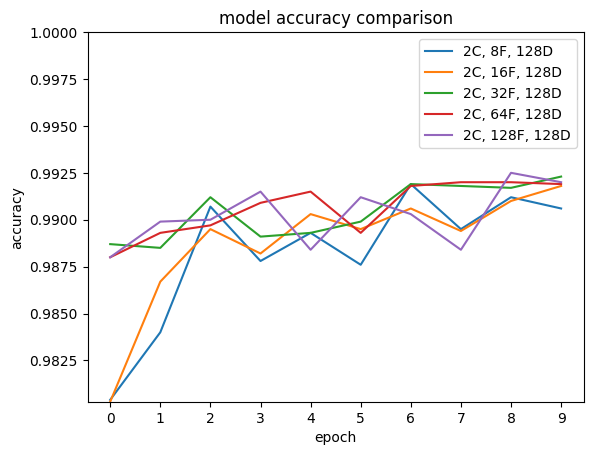

In [39]:
fig, ax = plt.subplots()
names = []

for i in range(len(history)) :
    ax.plot(history[i].history['val_accuracy'])
    names.append(models[i][1])
    
ax.set_title('model accuracy comparison')
ax.set_ylabel('accuracy')   
ax.set_xlabel('epoch') 
ax.set_xticks(range(0, history[0].params['epochs']))
ax.set_ylim([min(map(lambda h: min(h.history['val_accuracy']), history)), 1])

plt.legend(names)
plt.show()